In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.model_selection import train_test_split
import os
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
import random
from pydub import AudioSegment
from pydub.playback import play

# Data Preprocessing

Here we load in our images and classes using image_dataset_from_directory which automatically gathers the 20 classes from the 20 folders the spectrograms reside in. Each image is resized to 224x224 and an even class distribution is created. Then the data is split into 80-20 train test and tensorflow datasets are created from the splits. 

In [1]:
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224

data_dir = os.getcwd() + "/data/spectrograms_windowed_dataset"
batch_size = 32
img_size = (IMAGE_HEIGHT, IMAGE_WIDTH) 

## Load the full dataset without splitting ##
full_ds = image_dataset_from_directory(
    data_dir,
    image_size=img_size,
    batch_size=1, 
    label_mode='int',
    shuffle=False
)

## create arrays of paths and labels and find limiting class size ##
image_paths = []
labels = []

for image, label in full_ds:
    image_paths.append(image.numpy()[0])  # Get the single image path
    labels.append(label.numpy()[0])  # Get the single label


labels = np.array(labels)
class_counts = defaultdict(int)
for label in labels:
    class_counts[label] += 1

max_samples_per_class = min(class_counts.values())

## Balance the dataset ##
balanced_image_paths = []
balanced_labels = []

class_sample_counts = defaultdict(int)

for image, label in zip(image_paths, labels):
    if class_sample_counts[label] < max_samples_per_class:
        balanced_image_paths.append(image)
        balanced_labels.append(label)
        class_sample_counts[label] += 1

## Split into train and test ##
train_images, val_images, train_labels, val_labels = train_test_split(
    balanced_image_paths, balanced_labels, test_size=0.2, stratify=balanced_labels, random_state=123
)

## Create TensorFlow datasets from the splits ##
def create_dataset(image_paths, labels, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(lambda x, y: (tf.image.resize(x, img_size), y))  # Resize images
    dataset = dataset.batch(batch_size)
    return dataset

train_ds = create_dataset(train_images, train_labels, batch_size)
val_ds = create_dataset(val_images, val_labels, batch_size)

## Normalize images (scale pixel values to [0, 1]) ##
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

## Cache and optimize performance ##
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

print("Class distributions after balancing:")
train_class_counts = defaultdict(int)
val_class_counts = defaultdict(int)

for _, labels in train_ds:
    for label in labels.numpy():
        train_class_counts[label] += 1

for _, labels in val_ds:
    for label in labels.numpy():
        val_class_counts[label] += 1

print(f"Training set: {dict(train_class_counts)}")
print(f"Validation set: {dict(val_class_counts)}")

Found 6692 files belonging to 20 classes.


2024-12-09 18:16:58.517657: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Class distributions after balancing:


2024-12-09 18:19:37.031905: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Training set: {0: 178, 17: 179, 6: 178, 11: 178, 10: 178, 7: 179, 15: 178, 14: 179, 19: 179, 18: 178, 9: 178, 8: 179, 3: 178, 13: 178, 12: 179, 4: 179, 2: 178, 5: 179, 16: 178, 1: 178}
Validation set: {19: 44, 3: 45, 2: 45, 16: 45, 1: 45, 15: 45, 7: 44, 5: 44, 18: 45, 0: 45, 8: 44, 14: 44, 13: 45, 4: 44, 6: 45, 9: 45, 17: 44, 12: 44, 11: 45, 10: 45}


Graph the class distribution to confirm equal class distribution for train and test sets

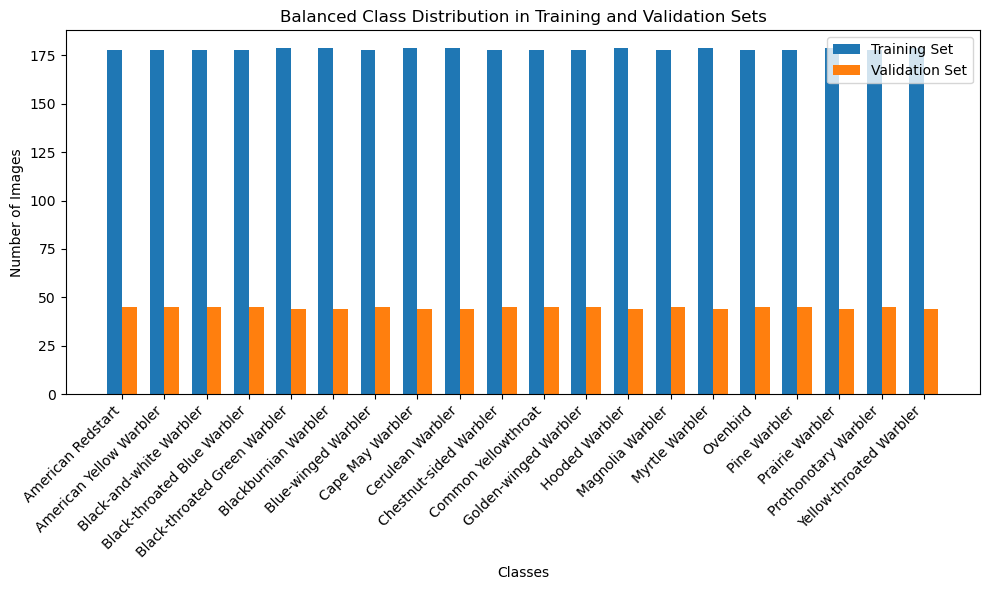

In [2]:
class_names = sorted(os.listdir(data_dir))
class_names = [name for name in class_names if os.path.isdir(os.path.join(data_dir, name))]  # Filter out non-directory files

# Convert class counts to lists
train_counts = [train_class_counts[class_label] for class_label in sorted(train_class_counts.keys())]
val_counts = [val_class_counts[class_label] for class_label in sorted(val_class_counts.keys())]

# plotting stuff
x = np.arange(len(class_names))  
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35
bar1 = ax.bar(x - bar_width/2, train_counts, bar_width, label='Training Set')
bar2 = ax.bar(x + bar_width/2, val_counts, bar_width, label='Validation Set')
ax.set_xlabel('Classes')
ax.set_ylabel('Number of Images')
ax.set_title('Balanced Class Distribution in Training and Validation Sets')
ax.set_xticks(x)
ax.set_xticklabels(class_names, rotation=45, ha='right')
ax.legend()
plt.tight_layout()
plt.show()

# Build CNN Model

Here we define and build a from scratch model with 3 convolutional layers and a final dense layer. With 224x224 images as input, we create 11 million parameters which we found was a good number for the amount of data we have

In [3]:
def build_cnn(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), num_classes=20):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),  # Regularization to prevent overfitting
        layers.Dense(num_classes, activation='softmax')  # Output layer
    ])
    return model

num_classes = 20 
model = build_cnn(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), num_classes=num_classes)

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 20)             │         2,580 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,171,540 (42.62 MB)

 Trainable params: 11,171,540 (42.62 MB)

 Non-trainable params: 0 (0.00 B)

# Train CNN Model

Train the model up to 30 epochs wiht early stopping monitor on validation loss. Restore the best version of the model before overtraining once detected. Model usually runs for about 15 epochs

In [4]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode = 'min',
    patience=4,
    restore_best_weights=True,
    verbose =1
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[early_stopping]
)

Epoch 1/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 48s 419ms/step - accuracy: 0.0603 - loss: 3.0650 - val_accuracy: 0.1110 - val_loss: 2.7689
Epoch 2/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 46s 408ms/step - accuracy: 0.1519 - loss: 2.6953 - val_accuracy: 0.2870 - val_loss: 2.2306
Epoch 3/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 47s 422ms/step - accuracy: 0.2903 - loss: 2.1955 - val_accuracy: 0.4563 - val_loss: 1.7696
Epoch 4/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 48s 431ms/step - accuracy: 0.4342 - loss: 1.7393 - val_accuracy: 0.5471 - val_loss: 1.4595
Epoch 5/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 49s 436ms/step - accuracy: 0.5517 - loss: 1.3856 - val_accuracy: 0.6110 - val_loss: 1.2476
Epoch 6/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 49s 435ms/step - accuracy: 0.6492 - loss: 1.0715 - val_accuracy: 0.6592 - val_loss: 1.0396
Epoch 7/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 49s 438ms/step - accuracy: 0.7224 - loss: 0.8678 - val_accuracy: 0.6928 - val_loss: 0.9914
Epoch 8/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 49s 437ms/step - accuracy: 0.7642 - loss: 0

# Evaluating Model

Get a basic accuracy measure and then plot the training and validation accuracy and loss to look for overfitting. 

In [5]:
val_loss, val_acc = model.evaluate(val_ds)
print(f"Validation Accuracy: {val_acc:.2f}")


28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 0.7546 - loss: 0.8538
Validation Accuracy: 0.76


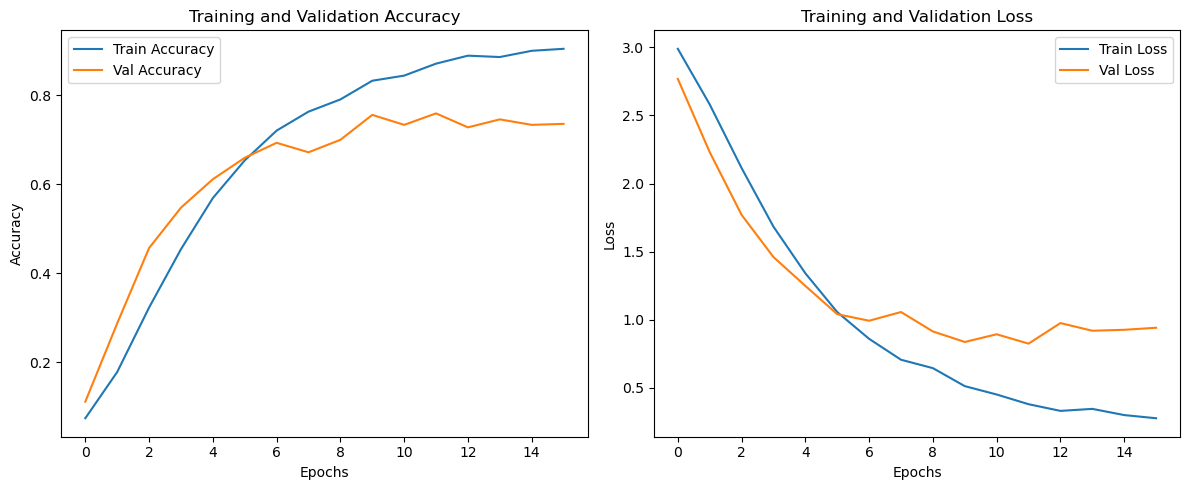

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# accuracy
axes[0].plot(history.history['accuracy'], label='Train Accuracy')
axes[0].plot(history.history['val_accuracy'], label='Val Accuracy')
axes[0].legend()
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Training and Validation Accuracy')

# loss
axes[1].plot(history.history['loss'], label='Train Loss')
axes[1].plot(history.history['val_loss'], label='Val Loss')
axes[1].legend()
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].set_title('Training and Validation Loss')

plt.tight_layout()
plt.show()

# Random spot testing

Here we will chose a random spectrogram from the dataset and we will print it's actual class, and predicted class. Then we will print its spectrogram and play the corresponding audio clip! Hopefully this will work live in class.

File Path: /Users/solomongreene/DIS/DIS Core Course/data/spectrograms_windowed_dataset/Magnolia Warbler/XC599656_6.png
True Class: Magnolia Warbler
Predicted Class: Magnolia Warbler


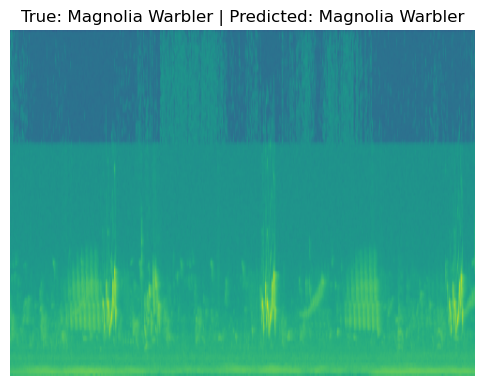

In [16]:
def decode_label(label):
    return class_names[label]

class_dirs = [os.path.join(data_dir, class_name) for class_name in class_names]

# Choose random image
random_class_dir = random.choice(class_dirs)
random_image = random.choice(os.listdir(random_class_dir))
image_path = os.path.join(random_class_dir, random_image)

# Load and preprocess the image
image = tf.keras.utils.load_img(image_path, target_size=img_size)
image_array = tf.keras.utils.img_to_array(image) / 255.0  # Normalize to [0, 1]
image_array = np.expand_dims(image_array, axis=0)  # Add batch dimension

# Get the true class name from the folder structure
true_label = os.path.basename(random_class_dir)

# Predict the class
prediction = model.predict(image_array, verbose=0)
predicted_label = np.argmax(prediction, axis=1)[0]

# Print results
print(f"File Path: {image_path}")
print(f"True Class: {true_label}")
print(f"Predicted Class: {decode_label(predicted_label)}")

# Display spectrogram
plt.figure(figsize=(6, 6))
plt.imshow(tf.keras.utils.load_img(image_path))  # Display the image
plt.title(f"True: {true_label} | Predicted: {decode_label(predicted_label)}")
plt.axis("off")
plt.show()

In [20]:
# Define a mapping from original folder names to new folder names
folder_name_mapping = {
    "Black-and-white Warbler": "Mniotilta varia_Black-and-white Warbler",
    "Magnolia Warbler": "Setophaga magnolia_Magnolia Warbler",
    "Common Yellowthroat": "Geothlypis trichas_Common Yellowthroat", 
    "Prothonotary Warbler": "Protonotaria citrea_Prothonotary Warbler", 
    "Ovenbird": "Seiurus aurocapilla_Ovenbird", 
    "American Yellow Warbler": "Setophaga aestiva_American Yellow Warbler", 
    "Black-throated Blue Warbler": "Setophaga caerulescens_Black-throated Blue Warbler", 
    "Cerulean Warbler": "Setophaga cerulea_Cerulean Warbler", 
    "Hooded Warbler": "Setophaga citrina_Hooded Warbler", 
    "Myrtle Warbler": "Setophaga coronata_Myrtle Warbler", 
    "Prairie Warbler": "Setophaga discolor_Prairie Warbler", 
    "Yellow-throated Warbler": "Setophaga dominica_Yellow-throated Warbler", 
    "Blackburnian Warbler": "Setophaga fusca_Blackburnian Warbler", 
    "Chestnut-sided Warbler": "Setophaga pensylvanica_Chestnut-sided Warbler", 
    "Pine Warbler": "Setophaga pinus_Pine Warbler", 
    "American Redstart": "Setophaga ruticilla_American Redstart", 
    "Cape May Warbler": "Setophaga tigrina_Cape May Warbler", 
    "Black-throated Green Warbler": "Setophaga virens_Black-throated Green Warbler", 
    "Golden-winged Warbler": "Vermivora chrysoptera_Golden-winged Warbler", 
    "Blue-winged Warbler": "Vermivora cyanoptera_Blue-winged Warbler"
}

def transform_file_path(original_path):
    ## this method returns the audio file path from the image file path to then play the audio later ##
    old_folder = "spectrograms_windowed_dataset"
    new_folder = "bird_dataset"
    
    path_parts = original_path.split(os.sep)
    
    # Extract the folder and file details
    old_folder_index = path_parts.index(old_folder)
    bird_folder = path_parts[old_folder_index + 1]  # The bird-specific folder name
    file_name = path_parts[-1]
    
    # Extract the stem and save the suffix after the last underscore
    file_stem = os.path.splitext(file_name)[0]  # Remove the extension
    suffix_number = None
    if "_" in file_stem:
        file_stem, suffix = file_stem.rsplit("_", 1)  # Split at the last underscore
        if suffix.isdigit():  # Ensure the suffix is numeric
            suffix_number = int(suffix)
    
    new_file_name = f"{file_stem}.wav"  # Add the new extension
    
    # Replace the folder name using the mapping
    new_bird_folder = folder_name_mapping[bird_folder]
    
    # Construct the new path
    new_path_parts = (
        path_parts[:old_folder_index] +  # Path before the old folder
        [new_folder, new_bird_folder, new_file_name]  # New folder and file structure
    )
    transformed_path = os.sep.join(new_path_parts)
    
    return transformed_path, suffix_number

transformed_path1, suffix1 = transform_file_path(image_path)
print(f"Transformed Path: {transformed_path1}, Suffix: {suffix1}")

Transformed Path: /Users/solomongreene/DIS/DIS Core Course/data/bird_dataset/Setophaga magnolia_Magnolia Warbler/XC599656.wav, Suffix: 6


In [22]:
def play_audio_segment(file_path, suffix_number):
    # plays the corresponding 30-second audio clip based on the suffix number of the file path
    try:
        # Load
        audio = AudioSegment.from_file(file_path)
        
        # Calculate the start and end times (in milliseconds)
        start_time = (suffix_number - 1) * 10 * 1000  # (n-1)*10 seconds
        end_time = start_time + 30 * 1000  # 30 seconds from start time
        
        # Clip the audio segment
        audio_segment = audio[start_time:end_time]
        
        # Save and play the clipped audio
        print(f"Playing a 30-second clip from {start_time/1000:.1f}s to {end_time/1000:.1f}s from: {file_path}")
        audio_segment.export("temp_audio_clip.wav", format="wav")
        return Audio("temp_audio_clip.wav")
    except Exception as e:
        print(f"Error: Could not play audio. {e}")

audio_player = play_audio_segment(transformed_path1, suffix1)
audio_player

Playing a 30-second clip from 50.0s to 80.0s from: /Users/solomongreene/DIS/DIS Core Course/data/bird_dataset/Setophaga magnolia_Magnolia Warbler/XC599656.wav
